# COGS 118A - Final Project

# Chess Winner Prediction and Data Analysis

## Group members

- Kalam Park
- Kira Fleischer
- Cray Minor

# Abstract 
This section should be short and clearly stated. It should be a single paragraph <200 words.  It should summarize: 
- what your goal/problem is
- what the data used represents 
- the solution/what you did
- major results you came up with (mention how results are measured) 

__NB:__ this final project form is much more report-like than the proposal and the checkpoint. Think in terms of writing a paper with bits of code in the middle to make the plots/tables

The goal of the reserach is to take advatnage of Lichess's online recorded matches to determine the factors that most strongly influences winning and to build a model that is able to predict the winner based on the factors found. The data used in this project represents various quantitative and qualitative measures of the competitors (~20,000 matches), in which we will use Logistic Regression as a baseline model using the significant factors, and create a filtered dataset for further analysis and model selection. We currently plan to use the SVM and Random Forests algorithms to select the model whilst cross-validating the model using metrics such as precision, recall, F1 score, and accuracy. This research aims to contribute to the understanding of complex competition, as well as assist in developing game strategies that closely links to success.


# Background

Chess is one of the world's most popular strategy games to date, and its ever-growing popularity has been heavily expedited due to the growing number of online platforms (Chess.com, Lichess) and users. With numerous events, streams, tutors, and creators online, chess can now be played and learned virtually anytime, anywhere. With the insurmountable amount of variations, openings, and data that comes with chess, the average player likely just scracthes the surface in understanding the deep complexity the game consists of. The emergence of AI and machine learning have offered a solution to this common dilemma, by providing a way to compute the mass amounts of available data and train the computer to do the thinking for them. That being said, AI and chess bots are amongst the most well known examples, popular for its near perfect chess performance, as well as a way of cheating.<a name="lorenz"></a>[<sup>[1]</sup>](#lorenznote) There has also been a lot of research on chess analysis and playing, such as Stockfish project, an opensource chess analysis algorithm which can provide players with an after game review with one of the most powerful chessbots.<a name="lorenz"></a>[<sup>[2]</sup>](#lorenznote) Evidently such knowledge can be highly beneficial in strategizing moves, openings, and sequences.

Similarly, our proposed work aims to provide helpful information by analyzing 20,000 Lichess matches and highlighting the variables that most heavily influences a user to win the match. Upon gathering these factors, we plan to restructure and split the dataset in order to train a model into predicting a winner based on some user inputs. This in hopes will help users strategize between openings, first moves, and help determine if white pieces really have an inherent advantage in novice to professional level matches. <a name="lorenz"></a>[<sup>[3]</sup>](#lorenznote)


# Problem Statement

Each side starting with 16 pieces, 6 different roles, and 64 squares there are nearly 10^120 different chess game variations, also known as Shannon's Number, which is more than there are atoms in the observable universe. <a name="lorenz"></a>[<sup>[4]</sup>](#lorenznote) We will be looking at the different features contained within our data to see the highest correlated with a win for white(1), a win for black(0), or a draw (2). Logistic Regression will serve as our baseline classifier because of its simplicity and replicability. We will compare its performance to more complex algorithms such as Random Forests and Support Vector Machinees quantified using confusion matricies and a ROC curve. After evaluation we select the model that performs best on the test and validation sets and its ability to generalize, to provide a comprehensive analysis of these games and potential winning strategies. 


# Data

Detail how/where you obtained the data and cleaned it (if necessary)

If the data cleaning process is very long (e.g., elaborate text processing) consider describing it briefly here in text, and moving the actual clearning process to another notebook in your repo (include a link here!).  The idea behind this approach: this is a report, and if you blow up the flow of the report to include a lot of code it makes it hard to read.

Please give the following infomration for each dataset you are using
- link/reference to obtain it
- description of the size of the dataset (# of variables, # of observations)
- what an observation consists of
- what some critical variables are, how they are represented
- any special handling, transformations, cleaning, etc you have done should be demonstrated here!


### Chess Game Dataset - Lichess (https://www.kaggle.com/datasets/datasnaek/chess)
- A collection of ~20,000 recorded chess matches between two Lichess users 
- Contains 16 variables 
    - Game ID; 
    - Rated (T/F);
    - Start Time;
    - End Time;
    - Number of Turns;
    - Game Status;
    - Winner;
    - Time Increment;
    - White Player ID;
    - White Player Rating;
    - Black Player ID;
    - Black Player Rating;
    - All Moves in Standard Chess Notation;
    - Opening Eco (Standardised Code for any given opening, list here);
    - Opening Name;
    - Opening Ply (Number of moves in the opening phase)


- Evidently some varibales will be more impactful than others, some critical ones are as listed:
    - White/Black rating (ranking)
    - Opening move 
    - Piece colors

A lot of the categorzing is done for us since each opening move has a respective eco code. There are some varibales such as Game status and Winner that can be categorized numerically. We also plan to just completely remove some variables we believe should have no impact or influence on predicting who would win a game (ex: Game status, All Moves in Standard Chess Notation, Game ID, player IDs, etc.)


### Data Cleaning 

**Import relevant packages**

In [ ]:
import pandas as pd 
from sklearn.model_selection import train_test_split, LearningCurveDisplay, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

**Bring data csv into pandas dataframe & set match ID as index**

In [ ]:
df = pd.read_csv('data/games.csv').set_index('id')

#convert unix time so it's readable 
df['created_at'] = pd.to_datetime(df['created_at'], unit='ms')
df['last_move_at'] = pd.to_datetime(df['last_move_at'], unit='ms')
df.head(3)

,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
id,,,,,,,,,,,,,,,
TZJHLljE,False,2017-08-31 20:06:40,2017-08-31 20:06:40,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
l1NXvwaE,True,2017-08-30 21:53:20,2017-08-30 21:53:20,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
mIICvQHh,True,2017-08-30 21:53:20,2017-08-30 21:53:20,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20058 entries, TZJHLljE to N8G2JHGG
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   rated           20058 non-null  bool          
 1   created_at      20058 non-null  datetime64[ns]
 2   last_move_at    20058 non-null  datetime64[ns]
 3   turns           20058 non-null  int64         
 4   victory_status  20058 non-null  object        
 5   winner          20058 non-null  object        
 6   increment_code  20058 non-null  object        
 7   white_id        20058 non-null  object        
 8   white_rating    20058 non-null  int64         
 9   black_id        20058 non-null  object        
 10  black_rating    20058 non-null  int64         
 11  moves           20058 non-null  object        
 12  opening_eco     20058 non-null  object        
 13  opening_name    20058 non-null  object        
 14  opening_ply     20058 non-null  int64         
dt

**Remove user ID to preserve privacy and does not perrtain to our project purpose**

In [ ]:
df = df.drop(['white_id', 'black_id'], axis=1)

In [ ]:
print(f"First 11 openings:")
df['opening_name'].value_counts()[:11]

First 11 openings:


Van't Kruijs Opening                             368
Sicilian Defense                                 358
Sicilian Defense: Bowdler Attack                 296
Scotch Game                                      271
French Defense: Knight Variation                 271
Scandinavian Defense: Mieses-Kotroc Variation    259
Queen's Pawn Game: Mason Attack                  232
Queen's Pawn Game: Chigorin Variation            229
Scandinavian Defense                             223
Horwitz Defense                                  209
Caro-Kann Defense                                199
Name: opening_name, dtype: int64

In [ ]:
print("The best openings with white: ")

Gr_white = df[df['winner']=='white']
Gr_white[['opening_name', 'winner']].value_counts().sort_values(ascending=False)[:10]

The best openings with white: 


opening_name                                   winner
Scandinavian Defense: Mieses-Kotroc Variation  white     164
Sicilian Defense                               white     149
Scotch Game                                    white     145
French Defense: Knight Variation               white     135
Philidor Defense #3                            white     127
Van't Kruijs Opening                           white     126
Sicilian Defense: Bowdler Attack               white     119
Queen's Pawn Game: Mason Attack                white     116
Queen's Pawn Game: Chigorin Variation          white     112
Horwitz Defense                                white     110
dtype: int64

In [ ]:
print("The best openings with Black: ")

Gr_black = df[df['winner']=='black']
Gr_black[['opening_name', 'winner']].value_counts().sort_values(ascending=False)[:10]

The best openings with Black: 


opening_name                           winner
Van't Kruijs Opening                   black     226
Sicilian Defense                       black     194
Sicilian Defense: Bowdler Attack       black     164
Scandinavian Defense                   black     123
French Defense: Knight Variation       black     121
Scotch Game                            black     115
Queen's Pawn Game: Chigorin Variation  black     109
Queen's Pawn Game: Mason Attack        black     103
Indian Game                            black     100
Philidor Defense #2                    black      96
dtype: int64

**The opening name should also be removed, opening name is repetitive**

In [ ]:
df = df.drop(['opening_name'], axis=1)
df.head()

,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_rating,black_rating,moves,opening_eco,opening_ply
id,,,,,,,,,,,,
TZJHLljE,False,2017-08-31 20:06:40,2017-08-31 20:06:40,13,outoftime,white,15+2,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,5
l1NXvwaE,True,2017-08-30 21:53:20,2017-08-30 21:53:20,16,resign,black,5+10,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,4
mIICvQHh,True,2017-08-30 21:53:20,2017-08-30 21:53:20,61,mate,white,5+10,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,3
kWKvrqYL,True,2017-08-30 16:20:00,2017-08-30 16:20:00,61,mate,white,20+0,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,3
9tXo1AUZ,True,2017-08-29 18:06:40,2017-08-29 18:06:40,95,mate,white,30+3,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,5


**Check for missing values, NaNs, and nulls**


In [ ]:
df.isna().any()

rated             False
created_at        False
last_move_at      False
turns             False
victory_status    False
winner            False
increment_code    False
white_rating      False
black_rating      False
moves             False
opening_eco       False
opening_ply       False
dtype: bool

**If you take a look at the the created_at and last_move_at time columns, they are exactly the same, so delete them as well**


In [ ]:
df.head(2)

,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_rating,black_rating,moves,opening_eco,opening_ply
id,,,,,,,,,,,,
TZJHLljE,False,2017-08-31 20:06:40,2017-08-31 20:06:40,13,outoftime,white,15+2,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,5
l1NXvwaE,True,2017-08-30 21:53:20,2017-08-30 21:53:20,16,resign,black,5+10,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,4


In [ ]:
df = df.drop(['created_at', 'last_move_at'], axis=1)
df.head(2)

,rated,turns,victory_status,winner,increment_code,white_rating,black_rating,moves,opening_eco,opening_ply
id,,,,,,,,,,
TZJHLljE,False,13,outoftime,white,15+2,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,5
l1NXvwaE,True,16,resign,black,5+10,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,4


**Numerically encode the rated, winner, and victory_status column strings**

In [ ]:
df['rated'] = df['rated'].astype(int)
df['winner'] = df['winner'].replace({'white': 0, 'black': 1, 'draw': 2}).astype(int)
df['victory_status'] = df['victory_status'].replace({'mate': 0, 'resign': 1, 'draw': 2, 'outoftime': 3}).astype(int)

In [ ]:
df.head(10)

,rated,turns,victory_status,winner,increment_code,white_rating,black_rating,moves,opening_eco,opening_ply
id,,,,,,,,,,
TZJHLljE,0,13,3,0,15+2,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,5
l1NXvwaE,1,16,1,1,5+10,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,4
mIICvQHh,1,61,0,0,5+10,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,3
kWKvrqYL,1,61,0,0,20+0,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,3
9tXo1AUZ,1,95,0,0,30+3,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,5
MsoDV9wj,0,5,2,2,10+0,1250,1002,e4 c5 Nf3 Qa5 a3,B27,4
qwU9rasv,1,33,1,0,10+0,1520,1423,d4 d5 e4 dxe4 Nc3 Nf6 f3 exf3 Nxf3 Nc6 Bb5 a6 ...,D00,10
RVN0N3VK,0,9,1,1,15+30,1413,2108,e4 Nc6 d4 e5 d5 Nce7 c3 Ng6 b4,B00,5
dwF3DJHO,1,66,1,1,15+0,1439,1392,e4 e5 Bc4 Nc6 Nf3 Nd4 d3 Nxf3+ Qxf3 Nf6 h3 Bc5...,C50,6


In [ ]:
df.shape

(20058, 10)

Here's a link that go over the different eco codes and their groups/names: https://www.365chess.com/eco.php

**Instead of looking through a mass number of different moves and ecos, let's just consider the players' first moves for a cleaner analysis**

In [ ]:
#define a function that gets only the first two moves in the moves list 
def getFirstTwoMoves(moves):
    splitted = moves.split(maxsplit=2)
    if len(splitted) < 2:
        return np.nan, np.nan
    return splitted[0], splitted[1]

In [ ]:
#apply this function to the moves column and vectprize 
first_two_moves = np.vectorize(getFirstTwoMoves)(df['moves'])
df['white_first_move'], df['black_first_move'] = first_two_moves[0], first_two_moves[1]
df = df.drop(['opening_eco', 'moves'], axis=1)
df

,rated,turns,victory_status,winner,increment_code,white_rating,black_rating,opening_ply,white_first_move,black_first_move
id,,,,,,,,,,
TZJHLljE,0,13,3,0,15+2,1500,1191,5,d4,d5
l1NXvwaE,1,16,1,1,5+10,1322,1261,4,d4,Nc6
mIICvQHh,1,61,0,0,5+10,1496,1500,3,e4,e5
kWKvrqYL,1,61,0,0,20+0,1439,1454,3,d4,d5
9tXo1AUZ,1,95,0,0,30+3,1523,1469,5,e4,e5
...,...,...,...,...,...,...,...,...,...,...
EfqH7VVH,1,24,1,0,10+10,1691,1220,2,d4,f5
WSJDhbPl,1,82,0,1,10+0,1233,1196,2,d4,d6
yrAas0Kj,1,35,0,0,10+0,1219,1286,3,d4,d5


In [ ]:
df.isna().any()

rated               False
turns               False
victory_status      False
winner              False
increment_code      False
white_rating        False
black_rating        False
opening_ply         False
white_first_move    False
black_first_move    False
dtype: bool

**The time increment is hard to read and has way too many variations as well. So let's break them down and group them together solely based on the minutes allowed in the game and ignoring the extra seconds**

In [ ]:
def deletePlusSuffix(inc):
    splitted = inc.split('+')
    return int(splitted[0])

#group the following categories into their respective time groups
def CategorizeInc(inc):
    if inc < 3:
        return 'bullet'    
    elif inc < 9:
        return 'blitz'
    elif inc < 16:
        return 'rapid'
    else:
        return 'classical'

In [ ]:
#apply the functions to the increment_code column
df['increment_code'] = np.vectorize(deletePlusSuffix)(df['increment_code'])
df['increment_code'] = np.vectorize(CategorizeInc)(df['increment_code'])
df

,rated,turns,victory_status,winner,increment_code,white_rating,black_rating,opening_ply,white_first_move,black_first_move
id,,,,,,,,,,
TZJHLljE,0,13,3,0,rapid,1500,1191,5,d4,d5
l1NXvwaE,1,16,1,1,blitz,1322,1261,4,d4,Nc6
mIICvQHh,1,61,0,0,blitz,1496,1500,3,e4,e5
kWKvrqYL,1,61,0,0,classical,1439,1454,3,d4,d5
9tXo1AUZ,1,95,0,0,classical,1523,1469,5,e4,e5
...,...,...,...,...,...,...,...,...,...,...
EfqH7VVH,1,24,1,0,rapid,1691,1220,2,d4,f5
WSJDhbPl,1,82,0,1,rapid,1233,1196,2,d4,d6
yrAas0Kj,1,35,0,0,rapid,1219,1286,3,d4,d5


**It can be also beneficial to add a column that holds the disparity between the two players' ratings. The logic is higher disparity = greater probability to win**

In [ ]:
df['rating_difference'] = df['white_rating'] - df['black_rating']

**Check for duplicate games and delete them**

In [ ]:
print(f"\nNumber of rows before = {str(df.shape[0])[:2]},{str(df.shape[0])[2:]}")
print('Number of duplicated rows in data: ',df.duplicated().sum())

df = df.drop_duplicates()
print(f"\nNumber of rows after duplicate drop = {str(df.shape[0])[:2]},{str(df.shape[0])[2:]}")
print('Number of duplicated rows in data: ',df.duplicated().sum())


Number of rows before = 20,058
Number of duplicated rows in data:  947

Number of rows after duplicate drop = 19,111
Number of duplicated rows in data:  0


**here's the final dataframe**

In [ ]:
df

,rated,turns,victory_status,winner,increment_code,white_rating,black_rating,opening_ply,white_first_move,black_first_move,rating_difference
id,,,,,,,,,,,
TZJHLljE,0,13,3,0,rapid,1500,1191,5,d4,d5,309
l1NXvwaE,1,16,1,1,blitz,1322,1261,4,d4,Nc6,61
mIICvQHh,1,61,0,0,blitz,1496,1500,3,e4,e5,-4
kWKvrqYL,1,61,0,0,classical,1439,1454,3,d4,d5,-15
9tXo1AUZ,1,95,0,0,classical,1523,1469,5,e4,e5,54
...,...,...,...,...,...,...,...,...,...,...,...
EfqH7VVH,1,24,1,0,rapid,1691,1220,2,d4,f5,471
WSJDhbPl,1,82,0,1,rapid,1233,1196,2,d4,d6,37
yrAas0Kj,1,35,0,0,rapid,1219,1286,3,d4,d5,-67


# Proposed Solution

In order to predict the winner of the chess game, we will compare three different classification models and select the best one based on their respective performances, as measured by the evaluation metrics accuracy and f1 score. The three models we will use are:

1. Logistic Regression

Logistic regression is a method that aims to fit a linear decision boundary that separates classes based on their input features. Since there are three outcomes in our dataset, white win (1), black win (0), and draw (2), we will use use a one vs rest classifier in our logistic regression model to classify the three outcomes. In order to implement this model, we will split our dataset into training, validation, and test sets, where we will first train the model, tune the hyperparameters using the validation set, evaluate it based on accuracy and f1 score, and finally predict classifications using the test set. We will use gradient descent to find the best hyperparameters that minimize the loss function.

2. Random Forests

Random forests is a method that combines multiple decision trees that are each trained on a random subset of the training data and a random subset of the input features. We are using random forests because this method has many advantages over simple decision trees. For instance, random forests reduce overfitting by averaging the predictions of many decision trees. More importantly, however, random forests provide a measure of the importance of each feature by evaluating how much the performance of the model changes when different features are removed. This will help us determine which feature (player ratings, opening moves, piece color, etc.) are most important in predicting a winner. We will follow a similar method as with Logistic Regression to evaluate our Random Forests model. That is, we will split the data into training and test sets, train the model on the training set, tune the hyperparameters on the training set using k-fold cross-validation, evaluate the model based on accuaracy and f1 score, and finally predict classifications using the test set.

3. SVM

SVM is a method that aims to find a hyperplane that separates classes while creating the largest margin between the classes, which is determined by support vectors within the classes. This is achieved by minimizing a loss function that accounts for both misclassification errors and points that are within the margin surrounding the decision boundary hyperplane. We will most likely use linear SVM since this handles large datasets well, and we do not anticipate any curvature to or nonlinear patters in the data. As with the Logistic Regression and Random Forests models, we will begin by splitting our data set into training and test sets. Then we will train the model on the traning set using a one vs one classifier. Next we will tune the hyperparameters on the training set using k-fold cross-validation and evaluate the model based on accuracy and f1 score, and finally we will predict classifications using the test set.

# Evaluation Metrics

We will evaluate our model performances using the metrics accuracy and f1 score. 

Accuracy will be calculated by dividing the the number of correct predictions (e.g. white predicted to win and white actually wins) by the number of total predictions (the total training set size):

    accuracy = (number of correct predictions) / (number of total predictions)

This will give a pretty good estimate of which model is best at accurately predicting who will win since this is the most direct computation. 

Additionally, we will calculate the f1 score to compare our models. Since there are 3 outcomes in our classification problem, we must use a weighted average f1 score. That means precision, recall, and f1 score will be calculated 3 times each. Each class (white win, black win, and draw) will serve as the positive class for one round of calculations, with the remaining two classes serving as the negative class. For example, for one calculation of precision, recall and f1 score, white win will be the positive class, and black win or draw will be the negative class. Precision, recall, and f1 score will be calculated by the following formulae:

    TP = number of instances correctly classified as positive class (e.g. white win predicted as white win)
    FP = number of instances incorrectly classified as positive class (e.g. black win or draw predicted as white win)
    FN = number of instances incorrectly classified as negative class (e.g. white win predicted as black win or draw)
    TN = number of instances correctly classified as negative class (e.g. black win or draw predicted as black win or draw)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 score = (2 * precision * recall) / (precision + recall)

To calculate the weighted average f1 score, we will use the following formulae:

    N_white_win = number of instances in dataset of white win
    N_black_win = number of instances in dataset of black win
    N_draw = number of instances in dataset of draw
    N_total = number of total instances in dataset
    f1 weighted average = ((F1 score white win * N_white_win) + (F1 score black win * N_black_win) + (F1 score draw * N_draw)) / N_total

We wanted to use the weighted average f1 score to account for the imbalanced class sizes we have, since there are significantly fewer instances of draws than of white wins or black wins. The weighted average f1 score gives more weight to classes that have more instances, so this works well in our situation.

In [ ]:
#X = df.drop('winner', axis = 1)
#y = df['winner']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#log_reg = LogisticRegression()
#log_reg.fit(X_train, y_train)

In [ ]:
#y_pred = log_reg.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred)
#print(accuracy)

In [ ]:
#f1 = f1_score(y_test,y_pred, average = 'weighted')
#precision = precision_score(y_test,y_pred, average = 'weighted')
#recall = recall_score(y_test, y_pred, average = 'weighted')
#print("F1 Score:", f1, "Precision:", precision, "Recall Score:", recall)

In [ ]:
#cm = confusion_matrix(y_test, y_pred)
#disp = ConfusionMatrixDisplay(cm)
#disp.plot()
#plt.show()

In [ ]:
#train_sizes, train_scores, test_scores = learning_curve(log_reg, X, y)
#display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Score")
#display.plot()
#plt.show()

# Results

You may have done tons of work on this. Not all of it belongs here. 

Reports should have a __narrative__. Once you've looked through all your results over the quarter, decide on one main point and 2-4 secondary points you want us to understand. Include the detailed code and analysis results of those points only; you should spend more time/code/plots on your main point than the others.

If you went down any blind alleys that you later decided to not pursue, please don't abuse the TAs time by throwing in 81 lines of code and 4 plots related to something you actually abandoned.  Consider deleting things that are not important to your narrative.  If its slightly relevant to the narrative or you just want us to know you tried something, you could keep it in by summarizing the result in this report in a sentence or two, moving the actual analysis to another file in your repo, and providing us a link to that file.

### EDA (Exploratory Data Analysis)

Exploratory Data Analysis on the final dataset, exploring the relatiosnhips between the different features and winning, as well as the relationships between the first moves between white and black.

### Subsection 2

Another likely section is if you are doing any feature selection through cross-validation or hand-design/validation of features/transformations of the data

### Subsection 3

Probably you need to describe the base model and demonstrate its performance.  Maybe you include a learning curve to show whether you have enough data to do train/validate/test split or have to go to k-folds or LOOCV or ???

### Subsection 4

Perhaps some exploration of the model selection (hyper-parameters) or algorithm selection task. Validation curves, plots showing the variability of perfromance across folds of the cross-validation, etc. If you're doing one, the outcome of the null hypothesis test or parsimony principle check to show how you are selecting the best model.

### Subsection 5 

Maybe you do model selection again, but using a different kind of metric than before?



### **Subsection 1** - EDA

In [ ]:
df #for reference 

,rated,turns,victory_status,winner,increment_code,white_rating,black_rating,opening_ply,white_first_move,black_first_move,rating_difference
id,,,,,,,,,,,
TZJHLljE,0,13,3,0,rapid,1500,1191,5,d4,d5,309
l1NXvwaE,1,16,1,1,blitz,1322,1261,4,d4,Nc6,61
mIICvQHh,1,61,0,0,blitz,1496,1500,3,e4,e5,-4
kWKvrqYL,1,61,0,0,classical,1439,1454,3,d4,d5,-15
9tXo1AUZ,1,95,0,0,classical,1523,1469,5,e4,e5,54
...,...,...,...,...,...,...,...,...,...,...,...
EfqH7VVH,1,24,1,0,rapid,1691,1220,2,d4,f5,471
WSJDhbPl,1,82,0,1,rapid,1233,1196,2,d4,d6,37
yrAas0Kj,1,35,0,0,rapid,1219,1286,3,d4,d5,-67


In [ ]:
labels = {0: 'white', 1: 'black', 2: 'draw'}

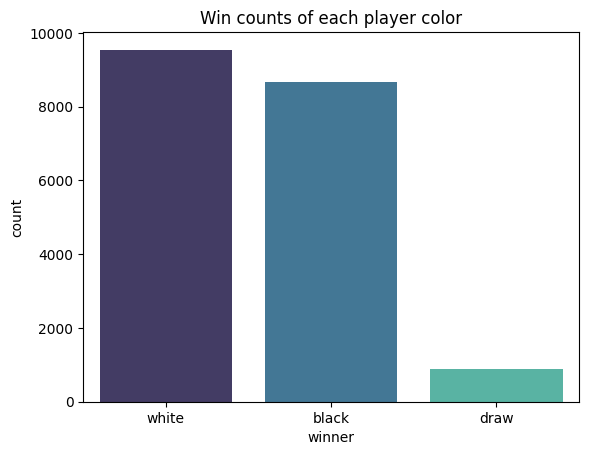

In [ ]:
ax = sns.countplot(data=df, x='winner', palette='mako')
ax.set(title='Win counts of each player color')
ax.set_xticklabels(['white', 'black', 'draw'])
plt.show()

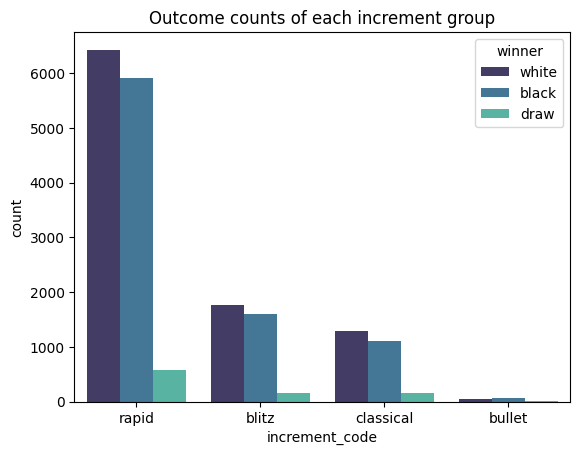

In [ ]:
ax = sns.countplot(data=df, x='increment_code', hue=df['winner'].map(labels), palette='mako')
ax.set(title='Outcome counts of each increment group')
plt.show()

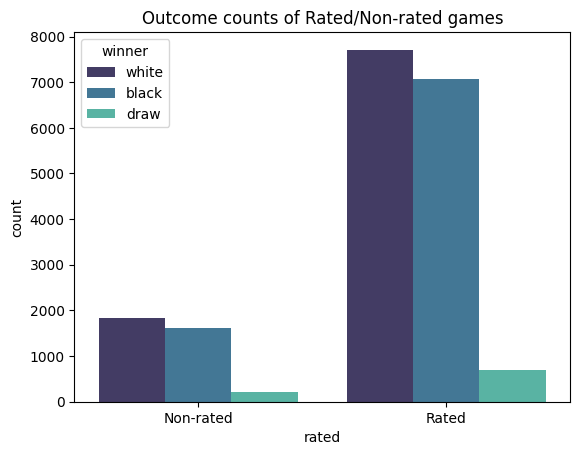

In [ ]:
ax = sns.countplot(data=df, x='rated', hue=df['winner'].map(labels), palette='mako')
ax.set(title='Outcome counts of Rated/Non-rated games')
ax.set_xticklabels(['Non-rated', 'Rated'])
plt.show()

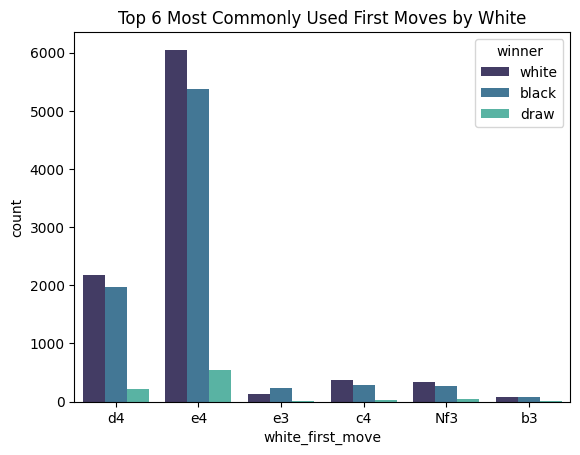

In [ ]:
fm = dict(df.white_first_move.value_counts(ascending=False)[0:6])
first_moves_w = list(fm.keys())
fm_df = df[df.white_first_move.isin(first_moves_w)]

ax = sns.countplot(data=fm_df, x='white_first_move', palette='mako', hue=df['winner'].map(labels))
ax.set(title='Top 6 Most Commonly Used First Moves by White')
plt.show()

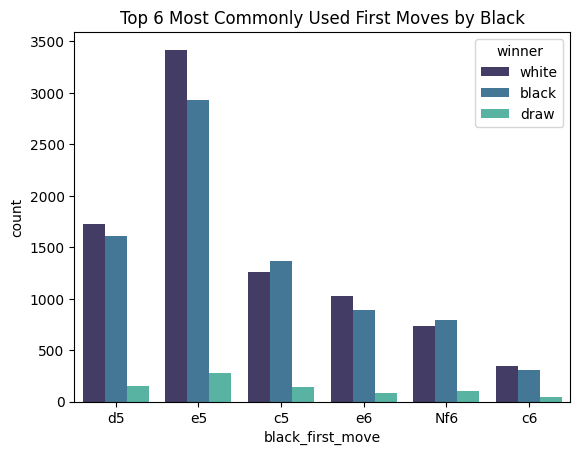

In [ ]:
fm1 = dict(df.black_first_move.value_counts(ascending=False)[0:6])
first_moves_b = list(fm1.keys())
fm1_df = df[df.black_first_move.isin(first_moves_b)]

ax = sns.countplot(data=fm1_df, x='black_first_move', palette='mako', hue=df['winner'].map(labels))
ax.set(title='Top 6 Most Commonly Used First Moves by Black')
plt.show()

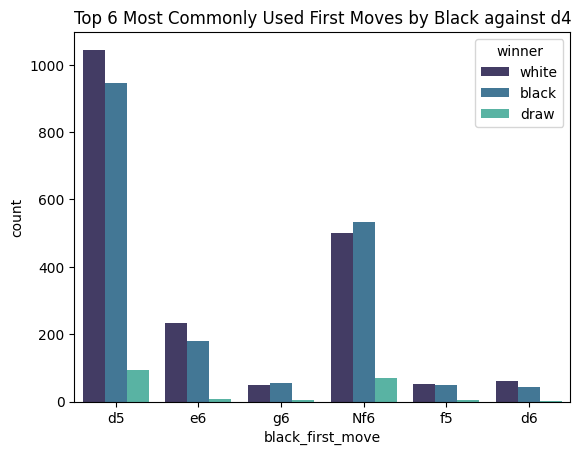

In [ ]:
fm_df = df.loc[df.white_first_move == 'd4']
fm = dict(fm_df.black_first_move.value_counts(ascending=False)[0:6])
b_d4 = list(fm.keys())
fm_df = fm_df[fm_df.black_first_move.isin(b_d4)]

ax = sns.countplot(data=fm_df, x='black_first_move', hue=df['winner'].map(labels), palette='mako')
ax.set(title='Top 6 Most Commonly Used First Moves by Black against d4')
plt.show()

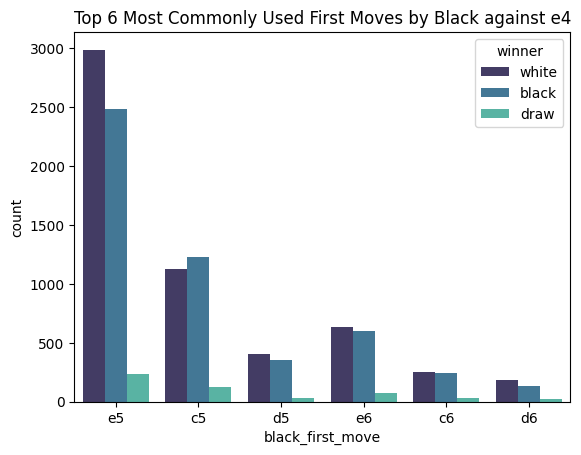

In [ ]:
fm_df1 = df.loc[df.white_first_move == 'e4']
fm1 = dict(fm_df1.black_first_move.value_counts(ascending=False)[0:6])
b_e4 = list(fm1.keys())
fm_df1 = fm_df1[fm_df1.black_first_move.isin(b_e4)]

ax = sns.countplot(data=fm_df1, x='black_first_move', hue=df['winner'].map(labels), palette='mako')
ax.set(title='Top 6 Most Commonly Used First Moves by Black against e4')
plt.show()

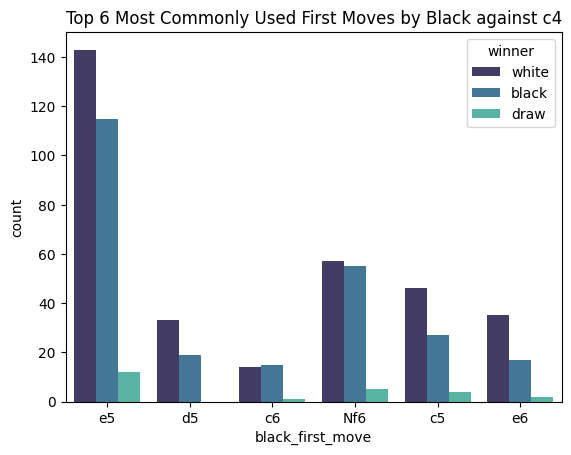

In [ ]:
fm_df2 = df.loc[df.white_first_move == 'c4']
fm2 = dict(fm_df2.black_first_move.value_counts(ascending=False)[0:6])
b_c4 = list(fm2.keys())
fm_df2 = fm_df2[fm_df2.black_first_move.isin(b_c4)]

ax = sns.countplot(data=fm_df2, x='black_first_move', hue=df['winner'].map(labels), palette='mako')
ax.set(title='Top 6 Most Commonly Used First Moves by Black against c4')
plt.show()

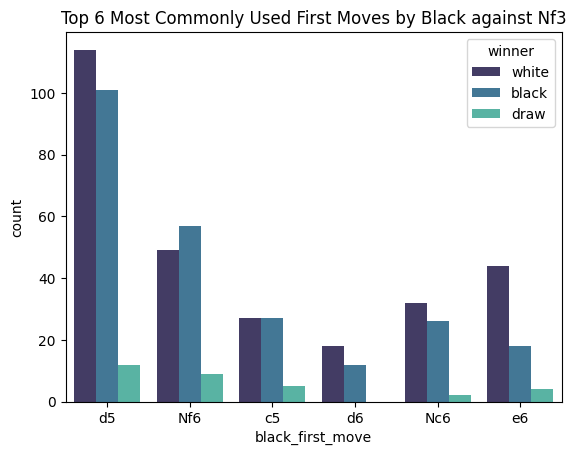

In [ ]:
fm_df3 = df.loc[df.white_first_move == 'Nf3']
fm3 = dict(fm_df3.black_first_move.value_counts(ascending=False)[0:6])
b_Nf3 = list(fm3.keys())
fm_df3 = fm_df3[fm_df3.black_first_move.isin(b_Nf3)]

ax = sns.countplot(data=fm_df3, x='black_first_move', hue=df['winner'].map(labels), palette='mako')
ax.set(title='Top 6 Most Commonly Used First Moves by Black against Nf3')
plt.show()

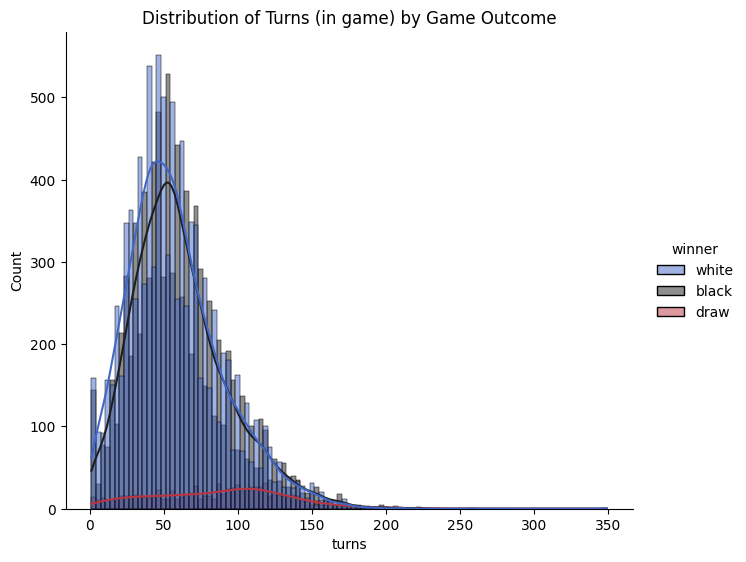

In [ ]:
ax = sns.displot(df, x='turns', hue=df['winner'].map(labels), palette='icefire', 
                 kde=True, height=5.5, aspect=1.2)
ax.set(title='Distribution of Turns (in game) by Game Outcome')
plt.show()

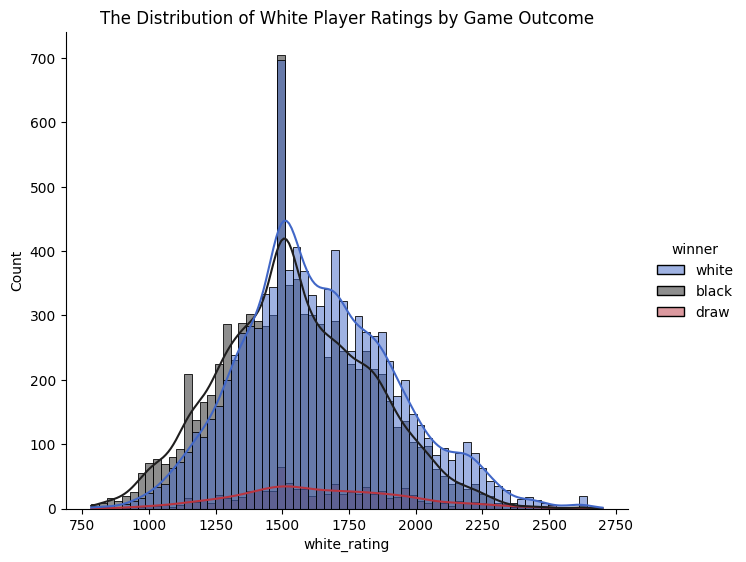

In [ ]:
ax = sns.displot(df, x='white_rating', hue=df['winner'].map(labels), palette='icefire', 
                 kde=True, height=5.5, aspect=1.2)
plt.title('The Distribution of White Player Ratings by Game Outcome')
plt.show()

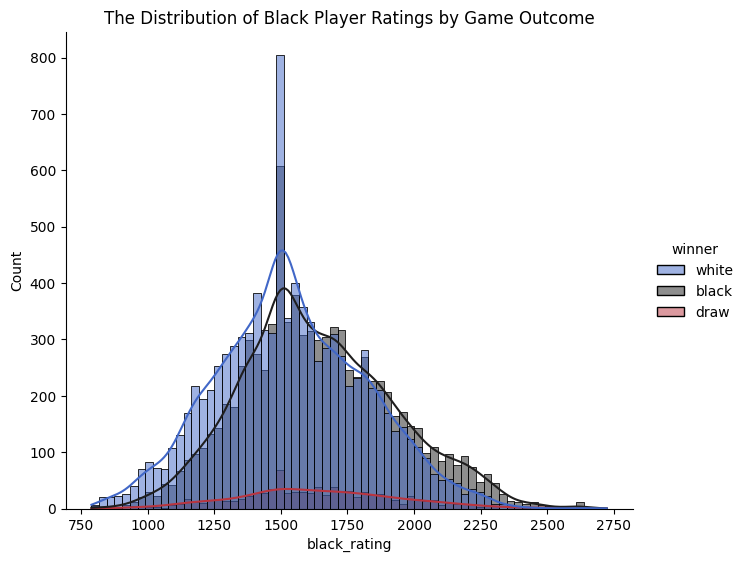

In [ ]:
ax = sns.displot(df, x='black_rating', hue=df['winner'].map(labels), palette='icefire', 
                 kde=True, height=5.5, aspect=1.2)
plt.title('The Distribution of Black Player Ratings by Game Outcome')
plt.show()

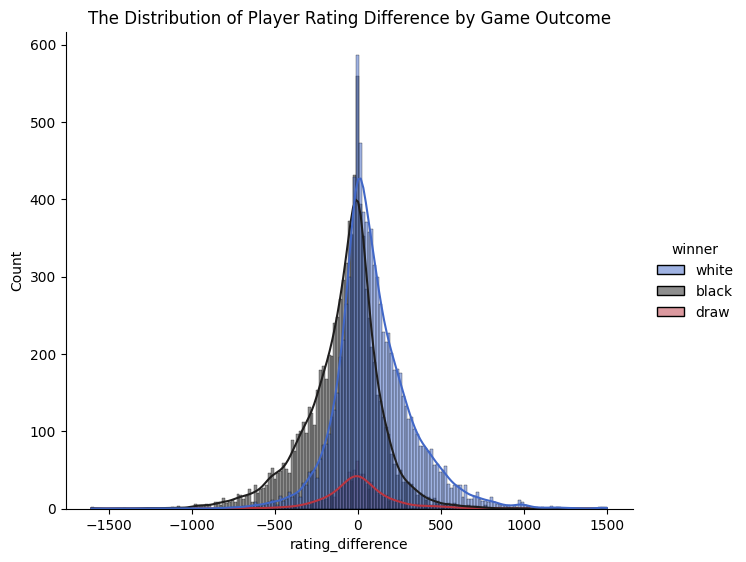

In [ ]:
ax = sns.displot(df, x='rating_difference', hue=df['winner'].map(labels), palette='icefire', 
                 kde=True, height=5.5, aspect=1.2)
plt.title('The Distribution of Player Rating Difference by Game Outcome')
plt.show()

# Section 2 - Feature selection & transformation

In [ ]:
df.head(2)

,rated,turns,victory_status,winner,increment_code,white_rating,black_rating,opening_ply,white_first_move,black_first_move,rating_difference
id,,,,,,,,,,,
TZJHLljE,0,13,3,0,rapid,1500,1191,5,d4,d5,309
l1NXvwaE,1,16,1,1,blitz,1322,1261,4,d4,Nc6,61


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif

X = df.drop('winner', axis=1)
y = df['winner']

# Transform categorical variables using one-hot encoding
cat_cols = ['increment_code', 'white_first_move', 'black_first_move']
num_cols = ['rated','turns','victory_status','winner', 'white_rating', 'black_rating', 'opening_ply', 'rating_difference']
transformer = ColumnTransformer([('one_hot', OneHotEncoder(), cat_cols)], remainder='passthrough')
X_transformed = transformer.fit_transform(X)

# Scale numerical variables
scaler = StandardScaler(with_mean = False)
X_transformed[:, -5:] = scaler.fit_transform(X_transformed[:, -5:])

# Perform feature selection using ANOVA F-value
selector = SelectKBest(score_func=f_classif, k=5)
X_selected = selector.fit_transform(X_transformed, y)

# Fit a logistic regression model with cross-validation
clf = LogisticRegression(max_iter=1000, random_state=42)
scores = cross_val_score(clf, X_selected, y, cv=10)

print('Accuracy scores:', scores)
print('Mean accuracy:', np.mean(scores))

Accuracy scores: [0.60146444 0.62480377 0.63579278 0.6122449  0.62009419 0.63736264
 0.61015175 0.61329147 0.60544218 0.62532705]
Mean accuracy: 0.6185975162514314


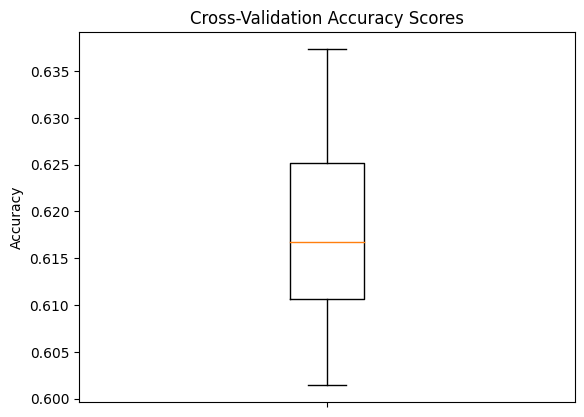

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(scores)
ax.set_title('Cross-Validation Accuracy Scores')
ax.set_ylabel('Accuracy')
ax.set_xticklabels([''])
plt.show()

# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.

### Limitations

Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for?   

### Ethics & Privacy

This project is from an online chess website Lichess, the data is freely available for collection and analysis. In order to address the any ethical concern of privacy, we will delete the Game ID and player ID variables so that there is no way to trace exact players or games, these variables are not important to our data analysis or model selection and will not otherwise affect our project nor the players from which the data is collected. Player ranking might also raise some ethical consideration, but because we are not keeping any identifying information about the player or game their privacy including ranking, will remain protected in our project. The results of this project does not raise any ethical or privacy concerns, but instead might offer players valuable insight to winning games.

### Conclusion

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

# Footnotes

<a name="lorenznote"></a>1.[^](#lorenz): The Impact of Artificial Intelligence on the Chess World, Duca Iliescu (2020) https://games.jmir.org/2020/4/e24049/

<a name="lorenznote"></a>2.[^](#lorenz): AlphaZero, Zhang & Yu (2020) https://link.springer.com/chapter/10.1007/978-981-15-4095-0_15

<a name="lorenznote"></a>3.[^](#lorenz): First Move Advantage in Chess https://en.wikipedia.org/wiki/First-move_advantage_in_chess

<a name="lorenznote"></a>4.[^](#lorenz): Which is greater? The number of atoms in the universe or the number of chess moves?, Kiernan https://www.liverpoolmuseums.org.
